In [1]:
"""
Complete pipeline for estimating TC track parameters (pressure, RMW, ROCI)
from basic track data and validating the results.

Input data requirements:
- lon_trks: longitude (°E)
- lat_trks: latitude (°N)
- vmax_trks: maximum wind speed (m/s)
- u250_trks, v250_trks: 250 hPa wind (m/s)
- u850_trks, v850_trks: 850 hPa wind (m/s)
- tc_basins: basin identifier
- tc_month, tc_years: temporal information
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import warnings

# =============================================================================
# CLIMADA ESTIMATION FUNCTIONS (from tc_tracks.py)
# =============================================================================

def _estimate_pressure(cen_pres, lat, lon, v_max):
    """
    Replace missing pressure values with statistical estimate.
    
    Statistical fit: r^2 = 0.8727
    From IBTrACS data (1980-2020)
    
    Parameters
    ----------
    cen_pres : array-like
        Central pressure values (hPa). Use np.nan for missing values.
    lat : array-like
        Latitude (degrees)
    lon : array-like
        Longitude (degrees)
    v_max : array-like
        Maximum wind speed (knots)
    
    Returns
    -------
    cen_pres_estimated : np.array
        Estimated central pressure (hPa)
    """
    cen_pres = np.where(np.isnan(cen_pres), -1, cen_pres)
    v_max = np.where(np.isnan(v_max), -1, v_max)
    lat, lon = [np.where(np.isnan(ar), -999, ar) for ar in [lat, lon]]
    msk = (cen_pres <= 0) & (v_max > 0) & (lat > -999) & (lon > -999)
    c_const, c_lat, c_lon, c_vmax = 1026.3401, -0.05504, -0.03536, -0.7357
    cen_pres[msk] = c_const + c_lat * lat[msk] + c_lon * lon[msk] + c_vmax * v_max[msk]
    return np.where(cen_pres <= 0, np.nan, cen_pres)


def estimate_rmw(rmw, cen_pres):
    """
    Replace missing RMW values with statistical estimate.
    
    Statistical fit: r^2 = 0.7906
    Piecewise linear interpolation based on pressure
    
    Parameters
    ----------
    rmw : array-like
        RMW values (nm). Use np.nan for missing values.
    cen_pres : array-like
        Central pressure (hPa)
    
    Returns
    -------
    rmw_estimated : np.array
        Estimated RMW (nm)
    """
    rmw = np.where(np.isnan(rmw), -1, rmw)
    cen_pres = np.where(np.isnan(cen_pres), -1, cen_pres)
    msk = (rmw <= 0) & (cen_pres > 0)
    pres_l = [872, 940, 980, 1021]
    rmw_l = [14.907318, 15.726927, 25.742142, 56.856522]
    rmw[msk] = 0
    for i, pres_l_i in enumerate(pres_l):
        slope_0 = 1.0 / (pres_l_i - pres_l[i - 1]) if i > 0 else 0
        slope_1 = 1.0 / (pres_l[i + 1] - pres_l_i) if i + 1 < len(pres_l) else 0
        rmw[msk] += rmw_l[i] * np.fmax(
            0,
            (1 - slope_0 * np.fmax(0, pres_l_i - cen_pres[msk])
             - slope_1 * np.fmax(0, cen_pres[msk] - pres_l_i))
        )
    return np.where(rmw <= 0, np.nan, rmw)


def estimate_roci(roci, cen_pres):
    """
    Replace missing ROCI values with statistical estimate.
    
    Statistical fit: r^2 = 0.9148
    Piecewise linear interpolation based on pressure
    
    Parameters
    ----------
    roci : array-like
        ROCI values (nm). Use np.nan for missing values.
    cen_pres : array-like
        Central pressure (hPa)
    
    Returns
    -------
    roci_estimated : np.array
        Estimated ROCI (nm)
    """
    roci = np.where(np.isnan(roci), -1, roci)
    cen_pres = np.where(np.isnan(cen_pres), -1, cen_pres)
    msk = (roci <= 0) & (cen_pres > 0)
    pres_l = [872, 950, 985, 1005, 1021]
    roci_l = [210.711487, 215.897110, 198.261520, 159.589508, 90.900116]
    roci[msk] = 0
    for i, pres_l_i in enumerate(pres_l):
        slope_0 = 1.0 / (pres_l_i - pres_l[i - 1]) if i > 0 else 0
        slope_1 = 1.0 / (pres_l[i + 1] - pres_l_i) if i + 1 < len(pres_l) else 0
        roci[msk] += roci_l[i] * np.fmax(
            0,
            (1 - slope_0 * np.fmax(0, pres_l_i - cen_pres[msk])
             - slope_1 * np.fmax(0, cen_pres[msk] - pres_l_i))
        )
    return np.where(roci <= 0, np.nan, roci)


# =============================================================================
# ALTERNATIVE ESTIMATION METHODS
# =============================================================================

def estimate_pressure_dvorak(vmax_kt):
    """
    Dvorak pressure-wind relationship (Knaff & Zehr 2007).
    Piecewise linear for different intensity ranges.
    
    Parameters
    ----------
    vmax_kt : array-like
        Maximum wind speed (knots)
    
    Returns
    -------
    pressure : np.array
        Central pressure (hPa)
    """
    pressure = np.zeros_like(vmax_kt, dtype=float)
    
    # Very weak (< 35 kt)
    mask = vmax_kt < 35
    pressure[mask] = 1013 - 0.1 * vmax_kt[mask]
    
    # Tropical storm (35-64 kt)
    mask = (vmax_kt >= 35) & (vmax_kt < 64)
    pressure[mask] = 1009.1 - 0.975 * (vmax_kt[mask] - 35)
    
    # Hurricane (64-100 kt)
    mask = (vmax_kt >= 64) & (vmax_kt < 100)
    pressure[mask] = 980.8 - 1.225 * (vmax_kt[mask] - 64)
    
    # Major hurricane (>= 100 kt)
    mask = vmax_kt >= 100
    pressure[mask] = 936.7 - 1.175 * (vmax_kt[mask] - 100)
    
    return np.clip(pressure, 870, 1013)


def estimate_rmw_willoughby(lat, vmax_kt):
    """
    Willoughby & Rahn (2004) RMW estimation.
    
    Parameters
    ----------
    lat : array-like
        Latitude (degrees)
    vmax_kt : array-like
        Maximum wind speed (knots)
    
    Returns
    -------
    rmw : np.array
        RMW (nm)
    """
    lat_abs = np.abs(lat)
    rmw = 46.4 * np.exp(-0.0155 * vmax_kt + 0.0169 * lat_abs)
    return np.maximum(rmw, 5)


def estimate_rmw_shear(vmax_kt, u850, v850, u250, v250):
    """
    Shear-aware RMW estimation.
    Based on observations that RMW increases with vertical wind shear.
    
    Parameters
    ----------
    vmax_kt : array-like
        Maximum wind speed (knots)
    u850, v850 : array-like
        850 hPa wind components (m/s)
    u250, v250 : array-like
        250 hPa wind components (m/s)
    
    Returns
    -------
    rmw : np.array
        RMW (nm)
    """
    # Calculate vertical wind shear (850-250 hPa)
    shear = np.sqrt((u250 - u850)**2 + (v250 - v850)**2)
    shear_kt = shear * 1.943844  # Convert m/s to knots
    
    # Base RMW (decreases with intensity)
    rmw_base = 51.6 * np.exp(-0.0223 * vmax_kt)
    
    # Adjust for shear (RMW increases with shear)
    rmw = rmw_base * (1 + 0.015 * shear_kt)
    
    return np.clip(rmw, 5, 100)


def estimate_roci_knaff(lat, vmax_kt):
    """
    Knaff et al. (2007) ROCI estimation.
    
    Parameters
    ----------
    lat : array-like
        Latitude (degrees)
    vmax_kt : array-like
        Maximum wind speed (knots)
    
    Returns
    -------
    roci : np.array
        ROCI (nm)
    """
    lat_abs = np.abs(lat)
    roci = 66.785 - 0.09102 * vmax_kt + 1.0619 * lat_abs
    return np.maximum(roci, 20)


# =============================================================================
# ENSEMBLE ESTIMATION
# =============================================================================

def ensemble_estimates(lat, lon, vmax_kt, u850, v850, u250, v250):
    """
    Combine multiple estimation methods for robust results.
    
    Returns
    -------
    estimates : dict
        Contains 'mean', 'std', and individual 'methods' for each parameter
    """
    # Method 1: CLIMADA
    pres_climada = _estimate_pressure(np.full(vmax_kt.shape, np.nan), lat, lon, vmax_kt)
    rmw_climada = estimate_rmw(np.full(vmax_kt.shape, np.nan), pres_climada)
    roci_climada = estimate_roci(np.full(vmax_kt.shape, np.nan), pres_climada)
    
    # Method 2: Alternative methods
    pres_dvorak = estimate_pressure_dvorak(vmax_kt)
    rmw_willoughby = estimate_rmw_willoughby(lat, vmax_kt)
    roci_knaff = estimate_roci_knaff(lat, vmax_kt)
    
    # Method 3: Shear-aware
    rmw_shear = estimate_rmw_shear(vmax_kt, u850, v850, u250, v250)
    
    # Combine with weights
    estimates = {
        'central_pressure': {
            'mean': 0.6 * pres_climada + 0.4 * pres_dvorak,
            'std': np.abs(pres_climada - pres_dvorak) / 2,
            'methods': {
                'climada': pres_climada,
                'dvorak': pres_dvorak
            }
        },
        'rmw': {
            'mean': 0.4 * rmw_climada + 0.3 * rmw_willoughby + 0.3 * rmw_shear,
            'std': np.std([rmw_climada, rmw_willoughby, rmw_shear], axis=0),
            'methods': {
                'climada': rmw_climada,
                'willoughby': rmw_willoughby,
                'shear': rmw_shear
            }
        },
        'roci': {
            'mean': 0.5 * roci_climada + 0.5 * roci_knaff,
            'std': np.abs(roci_climada - roci_knaff) / 2,
            'methods': {
                'climada': roci_climada,
                'knaff': roci_knaff
            }
        }
    }
    
    # Ensure ROCI >= RMW
    estimates['roci']['mean'] = np.fmax(estimates['rmw']['mean'], estimates['roci']['mean'])
    
    return estimates


# =============================================================================
# VALIDATION FUNCTIONS
# =============================================================================

def check_physical_consistency(central_pressure, rmw, roci, vmax_kt, lat):
    """
    Verify that estimates satisfy physical constraints.
    
    Returns
    -------
    issues : dict
        Dictionary of potential issues found
    passed : bool
        True if all checks passed
    """
    issues = {}
    
    # 1. ROCI should always be >= RMW
    if np.any(roci < rmw):
        n_violations = np.sum(roci < rmw)
        issues['roci_rmw'] = f"{n_violations} points where ROCI < RMW"
    
    # 2. Pressure should decrease with increasing wind speed
    valid_mask = ~(np.isnan(vmax_kt) | np.isnan(central_pressure))
    if np.sum(valid_mask) > 2:
        wind_pres_corr = np.corrcoef(vmax_kt[valid_mask], central_pressure[valid_mask])[0, 1]
        if wind_pres_corr > -0.7:
            issues['wind_pressure'] = f"Weak wind-pressure correlation: {wind_pres_corr:.3f} (should be < -0.7)"
    
    # 3. RMW should be reasonable (5-150 nm)
    if np.any(rmw < 5) or np.any(rmw > 150):
        issues['rmw_range'] = f"RMW out of typical range: {np.nanmin(rmw):.1f} to {np.nanmax(rmw):.1f} nm"
    
    # 4. ROCI should be reasonable (50-500 nm)
    if np.any(roci < 50) or np.any(roci > 500):
        issues['roci_range'] = f"ROCI out of typical range: {np.nanmin(roci):.1f} to {np.nanmax(roci):.1f} nm"
    
    # 5. Pressure should be in valid range
    if np.any(central_pressure < 870) or np.any(central_pressure > 1013):
        issues['pressure_range'] = f"Pressure out of range: {np.nanmin(central_pressure):.1f} to {np.nanmax(central_pressure):.1f} hPa"
    
    # 6. Check latitude dependence of RMW (should increase poleward)
    if len(lat) > 10:
        valid_mask = ~(np.isnan(lat) | np.isnan(rmw))
        if np.sum(valid_mask) > 10:
            corr, p_val = spearmanr(np.abs(lat[valid_mask]), rmw[valid_mask])
            if corr < 0 and p_val < 0.05:
                issues['rmw_latitude'] = f"RMW decreases with latitude: corr={corr:.3f}, p={p_val:.3f}"
    
    passed = len(issues) == 0
    return issues, passed


def print_validation_report(issues, passed):
    """Print a formatted validation report."""
    print("\n" + "="*70)
    print("PHYSICAL CONSISTENCY VALIDATION REPORT")
    print("="*70)
    
    if passed:
        print("✓ All physical consistency checks PASSED")
    else:
        print(f"✗ {len(issues)} issue(s) found:\n")
        for i, (check, message) in enumerate(issues.items(), 1):
            print(f"{i}. {check.upper().replace('_', ' ')}")
            print(f"   {message}\n")
    
    print("="*70)


# =============================================================================
# VISUALIZATION
# =============================================================================

def plot_validation(lat, lon, vmax_kt, estimates):
    """
    Create comprehensive diagnostic plots.
    
    Returns
    -------
    fig : matplotlib.figure.Figure
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Plot 1: Pressure vs Wind Speed
    ax = axes[0, 0]
    ax.scatter(vmax_kt, estimates['central_pressure']['mean'], alpha=0.6, s=30)
    if 'std' in estimates['central_pressure']:
        ax.errorbar(vmax_kt[::5], estimates['central_pressure']['mean'][::5],
                   yerr=estimates['central_pressure']['std'][::5],
                   fmt='none', alpha=0.3, color='gray')
    ax.set_xlabel('Wind Speed (kt)', fontsize=11)
    ax.set_ylabel('Central Pressure (hPa)', fontsize=11)
    ax.set_title('Pressure-Wind Relationship', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(alpha=0.3)
    
    # Plot 2: RMW vs Latitude
    ax = axes[0, 1]
    scatter = ax.scatter(np.abs(lat), estimates['rmw']['mean'], 
                        c=vmax_kt, cmap='YlOrRd', alpha=0.6, s=30)
    ax.set_xlabel('|Latitude| (°)', fontsize=11)
    ax.set_ylabel('RMW (nm)', fontsize=11)
    ax.set_title('RMW vs Latitude (colored by wind speed)', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Wind Speed (kt)', fontsize=10)
    
    # Plot 3: ROCI vs RMW
    ax = axes[0, 2]
    ax.scatter(estimates['rmw']['mean'], estimates['roci']['mean'], alpha=0.6, s=30)
    max_val = max(np.nanmax(estimates['rmw']['mean']), np.nanmax(estimates['roci']['mean']))
    ax.plot([0, max_val], [0, max_val], 'r--', label='1:1 line', linewidth=2)
    ax.set_xlabel('RMW (nm)', fontsize=11)
    ax.set_ylabel('ROCI (nm)', fontsize=11)
    ax.set_title('ROCI vs RMW', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Plot 4: Track with RMW
    ax = axes[1, 0]
    ax.plot(lon, lat, 'k-', alpha=0.3, linewidth=1)
    scatter = ax.scatter(lon, lat, c=estimates['rmw']['mean'], 
                        cmap='viridis', s=50, edgecolors='black', linewidth=0.5)
    ax.set_xlabel('Longitude (°E)', fontsize=11)
    ax.set_ylabel('Latitude (°N)', fontsize=11)
    ax.set_title('Track colored by RMW', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('RMW (nm)', fontsize=10)
    
    # Plot 5: Intensity evolution
    ax = axes[1, 1]
    time_steps = np.arange(len(vmax_kt))
    ax.plot(time_steps, vmax_kt, label='Wind Speed', color='blue', linewidth=2)
    ax.set_xlabel('Time Step', fontsize=11)
    ax.set_ylabel('Wind Speed (kt)', color='blue', fontsize=11)
    ax.tick_params(axis='y', labelcolor='blue')
    ax.grid(alpha=0.3)
    
    ax2 = ax.twinx()
    ax2.plot(time_steps, estimates['central_pressure']['mean'], 
            label='Pressure', color='red', linewidth=2)
    ax2.set_ylabel('Pressure (hPa)', color='red', fontsize=11)
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.invert_yaxis()
    ax.set_title('Storm Intensity Evolution', fontsize=12, fontweight='bold')
    
    # Plot 6: Method comparison for RMW
    ax = axes[1, 2]
    time_steps = np.arange(len(lat))
    
    # Plot individual methods
    colors = {'climada': 'blue', 'willoughby': 'green', 'shear': 'orange'}
    for method_name, method_data in estimates['rmw']['methods'].items():
        ax.plot(time_steps, method_data, '--', alpha=0.5, 
               label=method_name.capitalize(), color=colors.get(method_name, 'gray'))
    
    # Plot ensemble mean
    ax.plot(time_steps, estimates['rmw']['mean'], 'k-', linewidth=2, label='Ensemble Mean')
    
    # Add uncertainty band
    if 'std' in estimates['rmw']:
        ax.fill_between(time_steps,
                        estimates['rmw']['mean'] - estimates['rmw']['std'],
                        estimates['rmw']['mean'] + estimates['rmw']['std'],
                        alpha=0.2, color='gray', label='Uncertainty')
    
    ax.set_xlabel('Time Step', fontsize=11)
    ax.set_ylabel('RMW (nm)', fontsize=11)
    ax.set_title('RMW: Method Comparison', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig


def print_summary_statistics(estimates, vmax_kt, lat):
    """Print summary statistics of the estimates."""
    print("\n" + "="*70)
    print("SUMMARY STATISTICS")
    print("="*70)
    
    print("\nInput Data:")
    print(f"  Track length: {len(lat)} points")
    print(f"  Wind speed range: {np.nanmin(vmax_kt):.1f} - {np.nanmax(vmax_kt):.1f} kt")
    print(f"  Latitude range: {np.nanmin(lat):.2f}° - {np.nanmax(lat):.2f}°")
    
    print("\nCentral Pressure:")
    print(f"  Mean: {np.nanmean(estimates['central_pressure']['mean']):.1f} hPa")
    print(f"  Range: {np.nanmin(estimates['central_pressure']['mean']):.1f} - "
          f"{np.nanmax(estimates['central_pressure']['mean']):.1f} hPa")
    if 'std' in estimates['central_pressure']:
        print(f"  Mean uncertainty: ±{np.nanmean(estimates['central_pressure']['std']):.1f} hPa")
    
    print("\nRadius of Maximum Wind (RMW):")
    print(f"  Mean: {np.nanmean(estimates['rmw']['mean']):.1f} nm")
    print(f"  Range: {np.nanmin(estimates['rmw']['mean']):.1f} - "
          f"{np.nanmax(estimates['rmw']['mean']):.1f} nm")
    if 'std' in estimates['rmw']:
        print(f"  Mean uncertainty: ±{np.nanmean(estimates['rmw']['std']):.1f} nm")
    
    print("\nRadius of Outermost Closed Isobar (ROCI):")
    print(f"  Mean: {np.nanmean(estimates['roci']['mean']):.1f} nm")
    print(f"  Range: {np.nanmin(estimates['roci']['mean']):.1f} - "
          f"{np.nanmax(estimates['roci']['mean']):.1f} nm")
    if 'std' in estimates['roci']:
        print(f"  Mean uncertainty: ±{np.nanmean(estimates['roci']['std']):.1f} nm")
    
    print("\nMethod Agreement:")
    for param in ['central_pressure', 'rmw', 'roci']:
        if 'methods' in estimates[param] and len(estimates[param]['methods']) > 1:
            methods_data = list(estimates[param]['methods'].values())
            method_range = np.nanmax(methods_data, axis=0) - np.nanmin(methods_data, axis=0)
            print(f"  {param.upper()}: Mean spread = ±{np.nanmean(method_range):.1f}")
    
    print("="*70)


# =============================================================================
# MAIN PROCESSING FUNCTION
# =============================================================================

def process_track(lon_trks, lat_trks, vmax_trks, u850_trks, v850_trks, 
                 u250_trks, v250_trks, tc_basins=None, tc_month=None, 
                 tc_years=None, plot=True, verbose=True):
    """
    Complete pipeline for processing a single TC track.
    
    Parameters
    ----------
    lon_trks : array-like
        Longitude (°E)
    lat_trks : array-like
        Latitude (°N)
    vmax_trks : array-like
        Maximum wind speed (m/s)
    u850_trks, v850_trks : array-like
        850 hPa wind components (m/s)
    u250_trks, v250_trks : array-like
        250 hPa wind components (m/s)
    tc_basins : str, optional
        Basin identifier
    tc_month, tc_years : int, optional
        Temporal information
    plot : bool, optional
        Whether to create diagnostic plots. Default: True
    verbose : bool, optional
        Whether to print detailed output. Default: True
    
    Returns
    -------
    results : dict
        Dictionary containing:
        - 'estimates': All parameter estimates (mean, std, methods)
        - 'validation': Physical consistency check results
        - 'fig': matplotlib figure (if plot=True)
    """
    if verbose:
        print("\n" + "="*70)
        print("TC TRACK PARAMETER ESTIMATION PIPELINE")
        print("="*70)
        if tc_basins:
            print(f"Basin: {tc_basins}")
        if tc_years and tc_month:
            print(f"Date: {tc_years}/{tc_month}")
    
    # Convert arrays to numpy
    lon = np.asarray(lon_trks)
    lat = np.asarray(lat_trks)
    vmax_ms = np.asarray(vmax_trks)
    u850 = np.asarray(u850_trks)
    v850 = np.asarray(v850_trks)
    u250 = np.asarray(u250_trks)
    v250 = np.asarray(v250_trks)
    
    # Convert wind speed from m/s to knots
    MS_TO_KN = 1.943844
    vmax_kt = vmax_ms * MS_TO_KN
    
    if verbose:
        print(f"\nProcessing track with {len(lat)} points...")
        print(f"Wind speed range: {np.nanmin(vmax_kt):.1f} - {np.nanmax(vmax_kt):.1f} kt")
    
    # Run ensemble estimation
    if verbose:
        print("\nRunning ensemble estimation...")
    estimates = ensemble_estimates(lat, lon, vmax_kt, u850, v850, u250, v250)
    
    # Run validation
    if verbose:
        print("Running physical consistency checks...")
    issues, passed = check_physical_consistency(
        estimates['central_pressure']['mean'],
        estimates['rmw']['mean'],
        estimates['roci']['mean'],
        vmax_kt,
        lat
    )
    
    if verbose:
        print_validation_report(issues, passed)
        print_summary_statistics(estimates, vmax_kt, lat)
    
    # Create plots
    fig = None
    if plot:
        if verbose:
            print("\nGenerating diagnostic plots...")
        fig = plot_validation(lat, lon, vmax_kt, estimates)
        plt.show()
    
    results = {
        'estimates': estimates,
        'validation': {
            'issues': issues,
            'passed': passed
        },
        'fig': fig
    }
    
    if verbose:
        print("\n" + "="*70)
        print("PROCESSING COMPLETE")
        print("="*70)
    
    return results


# =============================================================================
# TAYLOR DIAGRAM FOR MODEL COMPARISON
# =============================================================================

def calculate_taylor_statistics(reference, model, weights=None):
    """
    Calculate statistics needed for Taylor diagram.
    
    Parameters
    ----------
    reference : array-like
        Reference (observed) values
    model : array-like
        Model (simulated) values
    weights : array-like, optional
        Weights for each point (e.g., by intensity)
    
    Returns
    -------
    stats : dict
        Dictionary with 'std_ratio', 'correlation', 'rmse'
    """
    # Remove NaN values
    mask = ~(np.isnan(reference) | np.isnan(model))
    ref = reference[mask]
    mod = model[mask]
    
    if weights is not None:
        w = weights[mask]
        w = w / np.sum(w)  # Normalize weights
    else:
        w = np.ones(len(ref)) / len(ref)
    
    # Calculate weighted statistics
    ref_mean = np.average(ref, weights=w)
    mod_mean = np.average(mod, weights=w)
    
    ref_anom = ref - ref_mean
    mod_anom = mod - mod_mean
    
    ref_std = np.sqrt(np.average(ref_anom**2, weights=w))
    mod_std = np.sqrt(np.average(mod_anom**2, weights=w))
    
    correlation = np.average(ref_anom * mod_anom, weights=w) / (ref_std * mod_std)
    std_ratio = mod_std / ref_std
    
    # Centered RMSE (removes bias)
    centered_rmse = np.sqrt(np.average((ref_anom - mod_anom)**2, weights=w))
    normalized_rmse = centered_rmse / ref_std
    
    return {
        'std_ratio': std_ratio,
        'correlation': correlation,
        'rmse': centered_rmse,
        'normalized_rmse': normalized_rmse,
        'ref_std': ref_std,
        'mod_std': mod_std
    }


def plot_taylor_diagram(taylor_stats_dict, reference_name='IBTrACS', 
                        title='Model Comparison', fig=None, colors=None):
    """
    Create a Taylor diagram comparing multiple models to reference data.
    
    Parameters
    ----------
    taylor_stats_dict : dict
        Dictionary with model names as keys and taylor statistics as values
        Each value should be a dict with 'std_ratio' and 'correlation'
    reference_name : str, optional
        Name of reference dataset
    title : str, optional
        Plot title
    fig : matplotlib.figure.Figure, optional
        Existing figure to plot on
    colors : dict, optional
        Dictionary mapping model names to colors
    
    Returns
    -------
    fig : matplotlib.figure.Figure
    ax : matplotlib.axes.Axes
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Arc
    import matplotlib.lines as mlines
    
    if fig is None:
        fig = plt.figure(figsize=(10, 8))
    
    # Create polar subplot
    ax = fig.add_subplot(111, projection='polar')
    
    # Set up the axes
    ax.set_theta_direction(-1)  # Clockwise
    ax.set_theta_zero_location('N')  # Zero at top
    ax.set_ylim(0, 1.65)
    ax.set_xlim(0, np.pi/2)  # 0 to 90 degrees
    
    # Draw grid circles for standard deviation
    std_levels = np.arange(0, 1.8, 0.2)
    for std in std_levels:
        circle = plt.Circle((0, 0), std, transform=ax.transData._b, 
                           fill=False, edgecolor='lightgray', linewidth=0.5)
        ax.add_artist(circle)
    
    # Draw radial lines for correlation
    corr_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
    for corr in corr_levels:
        theta = np.arccos(corr)
        ax.plot([theta, theta], [0, 1.65], 'k-', linewidth=0.5, alpha=0.3)
        # Add correlation labels
        if corr in [0.0, 0.5, 0.7, 0.9, 0.95, 0.99]:
            ax.text(theta, 1.7, f'{corr:.2f}', ha='center', va='bottom', fontsize=8)
    
    # Draw RMSE contours (centered)
    theta_range = np.linspace(0, np.pi/2, 100)
    rmse_levels = [0.5, 1.0, 1.5]
    for rmse in rmse_levels:
        # RMSE relationship: RMSE² = ref_std² + mod_std² - 2*ref_std*mod_std*corr
        # With normalized std_ratio: RMSE² = 1 + std_ratio² - 2*std_ratio*corr
        std_ratio_curve = []
        for theta in theta_range:
            corr = np.cos(theta)
            # Solve for std_ratio given RMSE
            # std_ratio² - 2*corr*std_ratio + (1 - RMSE²) = 0
            discriminant = 4*corr**2 - 4*(1 - rmse**2)
            if discriminant >= 0:
                std_ratio = (2*corr + np.sqrt(discriminant)) / 2
                std_ratio_curve.append(std_ratio)
            else:
                std_ratio_curve.append(np.nan)
        
        ax.plot(theta_range, std_ratio_curve, 'g--', linewidth=0.8, alpha=0.4)
        # Label RMSE contours
        if len(std_ratio_curve) > 0 and not np.isnan(std_ratio_curve[-1]):
            ax.text(theta_range[-1], std_ratio_curve[-1], f'RMSE={rmse:.1f}', 
                   fontsize=7, color='green', alpha=0.6)
    
    # Plot reference point (perfect correlation, std_ratio=1)
    ax.plot(0, 1, 'k*', markersize=15, label=reference_name, zorder=10)
    
    # Plot model points
    if colors is None:
        colors = {}
        color_cycle = plt.cm.tab10(np.linspace(0, 1, len(taylor_stats_dict)))
        for i, model in enumerate(taylor_stats_dict.keys()):
            colors[model] = color_cycle[i]
    
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    for i, (model_name, stats) in enumerate(taylor_stats_dict.items()):
        theta = np.arccos(np.clip(stats['correlation'], -1, 1))
        r = stats['std_ratio']
        color = colors.get(model_name, f'C{i}')
        marker = markers[i % len(markers)]
        
        ax.plot(theta, r, marker=marker, markersize=10, color=color,
               label=model_name, markeredgecolor='black', markeredgewidth=0.5)
    
    # Formatting
    ax.set_xlabel('Correlation', fontsize=11, labelpad=20)
    ax.set_ylabel('Normalized Standard Deviation', fontsize=11, labelpad=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
    # Add correlation labels on the arc
    ax.text(0, -0.15, '1.0', transform=ax.transAxes, ha='center', fontsize=9)
    ax.text(0.95, 0.5, '0.0', transform=ax.transAxes, ha='center', fontsize=9)
    
    # Title and legend
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)
    
    # Add text box with RMSE info
    textstr = 'Green dashed lines:\nCentered RMSE contours'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=8,
           verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    return fig, ax


def compare_models_to_ibtracs(model_tracks_dict, basin=None, variable='max_sustained_wind',
                              year_range=None, intensity_weight=False):
    """
    Compare multiple model outputs to IBTrACS historical data by basin.
    
    Parameters
    ----------
    model_tracks_dict : dict
        Dictionary with model names as keys and TCTracks objects as values
        Each TCTracks should have estimates already calculated
    basin : str, optional
        Basin to analyze ('NA', 'EP', 'WP', 'NI', 'SI', 'SP')
        If None, analyze all basins together
    variable : str, optional
        Variable to compare: 'max_sustained_wind', 'central_pressure', 
        'radius_max_wind', 'radius_oci'
    year_range : tuple, optional
        (start_year, end_year) for IBTrACS data
    intensity_weight : bool, optional
        Whether to weight by storm intensity
    
    Returns
    -------
    comparison : dict
        Dictionary with Taylor statistics for each model
    fig : matplotlib.figure.Figure
        Taylor diagram
    """
    from climada.hazard import TCTracks
    
    print("\n" + "="*70)
    print(f"COMPARING MODELS TO IBTRACS - {variable.upper()}")
    if basin:
        print(f"Basin: {basin}")
    if year_range:
        print(f"Years: {year_range[0]}-{year_range[1]}")
    print("="*70)
    
    # Load IBTrACS data
    print("\nLoading IBTrACS data...")
    ibtracs_kwargs = {
        'estimate_missing': True,
        'interpolate_missing': True
    }
    if basin:
        ibtracs_kwargs['basin'] = basin
    if year_range:
        ibtracs_kwargs['year_range'] = year_range
    
    ibtracs = TCTracks.from_ibtracs_netcdf(**ibtracs_kwargs)
    
    # Extract reference values
    ref_values = []
    ref_weights = []
    for track in ibtracs.data:
        values = track[variable].values
        ref_values.extend(values[~np.isnan(values)])
        if intensity_weight and variable != 'max_sustained_wind':
            weights = track['max_sustained_wind'].values[~np.isnan(values)]
            ref_weights.extend(weights)
    
    ref_values = np.array(ref_values)
    ref_weights = np.array(ref_weights) if intensity_weight else None
    
    print(f"IBTrACS: {len(ref_values)} data points from {len(ibtracs.data)} tracks")
    print(f"  Mean {variable}: {np.mean(ref_values):.2f}")
    print(f"  Std {variable}: {np.std(ref_values):.2f}")
    
    # Compare each model
    taylor_stats = {}
    print("\nComparing models:")
    
    for model_name, model_tracks in model_tracks_dict.items():
        print(f"\n  {model_name}:")
        
        # Extract model values
        model_values = []
        model_weights = []
        for track in model_tracks.data:
            if variable in track:
                values = track[variable].values
                model_values.extend(values[~np.isnan(values)])
                if intensity_weight and variable != 'max_sustained_wind':
                    weights = track['max_sustained_wind'].values[~np.isnan(values)]
                    model_weights.extend(weights)
        
        model_values = np.array(model_values)
        model_weights = np.array(model_weights) if intensity_weight else None
        
        print(f"    {len(model_values)} data points from {len(model_tracks.data)} tracks")
        print(f"    Mean {variable}: {np.mean(model_values):.2f}")
        print(f"    Std {variable}: {np.std(model_values):.2f}")
        
        # Subsample to match sizes if needed
        if len(model_values) > len(ref_values):
            idx = np.random.choice(len(model_values), len(ref_values), replace=False)
            model_values = model_values[idx]
            if model_weights is not None:
                model_weights = model_weights[idx]
        elif len(ref_values) > len(model_values):
            idx = np.random.choice(len(ref_values), len(model_values), replace=False)
            ref_subset = ref_values[idx]
            ref_weights_subset = ref_weights[idx] if ref_weights is not None else None
        else:
            ref_subset = ref_values
            ref_weights_subset = ref_weights
        
        # Calculate Taylor statistics
        stats = calculate_taylor_statistics(ref_subset, model_values, 
                                            weights=ref_weights_subset)
        taylor_stats[model_name] = stats
        
        print(f"    Correlation: {stats['correlation']:.3f}")
        print(f"    Std ratio: {stats['std_ratio']:.3f}")
        print(f"    Normalized RMSE: {stats['normalized_rmse']:.3f}")
    
    # Create Taylor diagram
    title = f"{variable.replace('_', ' ').title()} Comparison"
    if basin:
        title += f" - {basin} Basin"
    
    fig, ax = plot_taylor_diagram(taylor_stats, reference_name='IBTrACS', title=title)
    
    print("\n" + "="*70)
    
    return taylor_stats, fig


def compare_models_all_basins(model_tracks_dict, variable='max_sustained_wind',
                              year_range=None):
    """
    Create Taylor diagrams for all basins.
    
    Parameters
    ----------
    model_tracks_dict : dict
        Dictionary with model names as keys and TCTracks objects as values
    variable : str
        Variable to compare
    year_range : tuple, optional
        (start_year, end_year)
    
    Returns
    -------
    results : dict
        Dictionary with basin names as keys and (stats, fig) tuples as values
    """
    basins = ['NA', 'EP', 'WP', 'NI', 'SI', 'SP']
    results = {}
    
    for basin in basins:
        print(f"\n{'='*70}")
        print(f"Processing basin: {basin}")
        print(f"{'='*70}")
        
        try:
            stats, fig = compare_models_to_ibtracs(
                model_tracks_dict,
                basin=basin,
                variable=variable,
                year_range=year_range
            )
            results[basin] = (stats, fig)
            plt.show()
        except Exception as e:
            print(f"Error processing basin {basin}: {e}")
            continue
    
    return results


def create_multi_basin_summary(results_dict, variable='max_sustained_wind'):
    """
    Create a summary plot showing all basins.
    
    Parameters
    ----------
    results_dict : dict
        Output from compare_models_all_basins
    variable : str
        Variable name for title
    
    Returns
    -------
    fig : matplotlib.figure.Figure
    """
    n_basins = len(results_dict)
    n_cols = 3
    n_rows = int(np.ceil(n_basins / n_cols))
    
    fig = plt.figure(figsize=(18, 6*n_rows))
    
    for i, (basin, (stats, _)) in enumerate(results_dict.items(), 1):
        ax = fig.add_subplot(n_rows, n_cols, i, projection='polar')
        fig_temp = plt.figure()
        plot_taylor_diagram(stats, reference_name='IBTrACS',
                          title=f'{basin} Basin - {variable.replace("_", " ").title()}',
                          fig=fig_temp)
        plt.close(fig_temp)
    
    plt.tight_layout()
    return fig

In [ ]:



# =============================================================================
# EXAMPLE USAGE
# =============================================================================

if __name__ == "__main__":
    print("="*70)
    print("TC PARAMETER ESTIMATION AND MODEL COMPARISON PIPELINE")
    print("="*70)
    print("\n1. SINGLE TRACK PROCESSING")
    print("-" * 70)
    print("import xarray as xr")
    print("from idd_climate_models.tc_estimation import process_track")
    print("")
    print("# Load your track data from netCDF")
    print("ds = xr.open_dataset('your_track_file.nc')")
    print("")
    print("# Select a single track")
    print("track = ds.sel(year=0, n_trk=0)")
    print("")
    print("# Process the track")
    print("results = process_track(")
    print("    lon_trks=track.lon_trks.values,")
    print("    lat_trks=track.lat_trks.values,")
    print("    vmax_trks=track.vmax_trks.values,")
    print("    u850_trks=track.u850_trks.values,")
    print("    v850_trks=track.v850_trks.values,")
    print("    u250_trks=track.u250_trks.values,")
    print("    v250_trks=track.v250_trks.values,")
    print("    tc_basins=track.tc_basins.values.item(),")
    print("    plot=True,")
    print("    verbose=True")
    print(")")
    print("")
    print("# Access results")
    print("pressure = results['estimates']['central_pressure']['mean']")
    print("rmw = results['estimates']['rmw']['mean']")
    print("roci = results['estimates']['roci']['mean']")
    print("")
    print("\n2. MODEL COMPARISON TO IBTRACS")
    print("-" * 70)
    print("from climada.hazard import TCTracks")
    print("from idd_climate_models.tc_estimation import compare_models_to_ibtracs")
    print("")
    print("# Load your model tracks (with estimates already calculated)")
    print("model1_tracks = TCTracks.from_netcdf('model1_tracks/')")
    print("model2_tracks = TCTracks.from_netcdf('model2_tracks/')")
    print("model3_tracks = TCTracks.from_netcdf('model3_tracks/')")
    print("")
    print("# Create dictionary of models")
    print("models = {")
    print("    'Model 1': model1_tracks,")
    print("    'Model 2': model2_tracks,")
    print("    'Model 3': model3_tracks")
    print("}")
    print("")
    print("# Compare to IBTrACS for North Atlantic basin")
    print("stats, fig = compare_models_to_ibtracs(")
    print("    models,")
    print("    basin='NA',")
    print("    variable='max_sustained_wind',")
    print("    year_range=(1980, 2020)")
    print(")")
    print("")
    print("\n3. MULTI-BASIN COMPARISON")
    print("-" * 70)
    print("from idd_climate_models.tc_estimation import compare_models_all_basins")
    print("")
    print("# Compare across all basins")
    print("all_results = compare_models_all_basins(")
    print("    models,")
    print("    variable='central_pressure',")
    print("    year_range=(1980, 2020)")
    print(")")
    print("")
    print("# Access results for specific basin")
    print("na_stats, na_fig = all_results['NA']")
    print("")
    print("\n4. VARIABLES AVAILABLE FOR COMPARISON")
    print("-" * 70)
    print("  - 'max_sustained_wind'")
    print("  - 'central_pressure'")
    print("  - 'radius_max_wind'")
    print("  - 'radius_oci'")
    print("")
    print("\n5. BASINS AVAILABLE")
    print("-" * 70)
    print("  - 'NA': North Atlantic")
    print("  - 'EP': Eastern Pacific")
    print("  - 'WP': Western Pacific")
    print("  - 'NI': North Indian")
    print("  - 'SI': South Indian")
    print("  - 'SP': South Pacific")
    print("="*70)

TC PARAMETER ESTIMATION AND MODEL COMPARISON PIPELINE

1. SINGLE TRACK PROCESSING
----------------------------------------------------------------------
import xarray as xr
from tc_estimation import process_track

# Load your track data from netCDF
ds = xr.open_dataset('your_track_file.nc')

# Select a single track
track = ds.sel(year=0, n_trk=0)

# Process the track
results = process_track(
    lon_trks=track.lon_trks.values,
    lat_trks=track.lat_trks.values,
    vmax_trks=track.vmax_trks.values,
    u850_trks=track.u850_trks.values,
    v850_trks=track.v850_trks.values,
    u250_trks=track.u250_trks.values,
    v250_trks=track.v250_trks.values,
    tc_basins=track.tc_basins.values.item(),
    plot=True,
    verbose=True
)

# Access results
pressure = results['estimates']['central_pressure']['mean']
rmw = results['estimates']['rmw']['mean']
roci = results['estimates']['roci']['mean']


2. MODEL COMPARISON TO IBTRACS
-------------------------------------------------------------------


TC TRACK PARAMETER ESTIMATION PIPELINE
Basin: SI

Processing track with 721 points...
Wind speed range: 11.4 - 46.9 kt

Running ensemble estimation...
Running physical consistency checks...

PHYSICAL CONSISTENCY VALIDATION REPORT
✗ 1 issue(s) found:

1. PRESSURE RANGE
   Pressure out of range: 993.4 to 1015.5 hPa


SUMMARY STATISTICS

Input Data:
  Track length: 721 points
  Wind speed range: 11.4 - 46.9 kt
  Latitude range: -35.89° - -10.75°

Central Pressure:
  Mean: 1006.2 hPa
  Range: 993.4 - 1015.5 hPa
  Mean uncertainty: ±2.5 hPa

Radius of Maximum Wind (RMW):
  Mean: 45.0 nm
  Range: 30.7 - 61.5 nm
  Mean uncertainty: ±4.2 nm

Radius of Outermost Closed Isobar (ROCI):
  Mean: 121.1 nm
  Range: 102.5 - 136.8 nm
  Mean uncertainty: ±29.2 nm

Method Agreement:
  CENTRAL_PRESSURE: Mean spread = ±1.9
  RMW: Mean spread = ±9.9
  ROCI: Mean spread = ±58.4

Generating diagnostic plots...


/tmp/ipykernel_118770/2981137154.py:517: RuntimeWarning: All-NaN axis encountered
  method_range = np.nanmax(methods_data, axis=0) - np.nanmin(methods_data, axis=0)


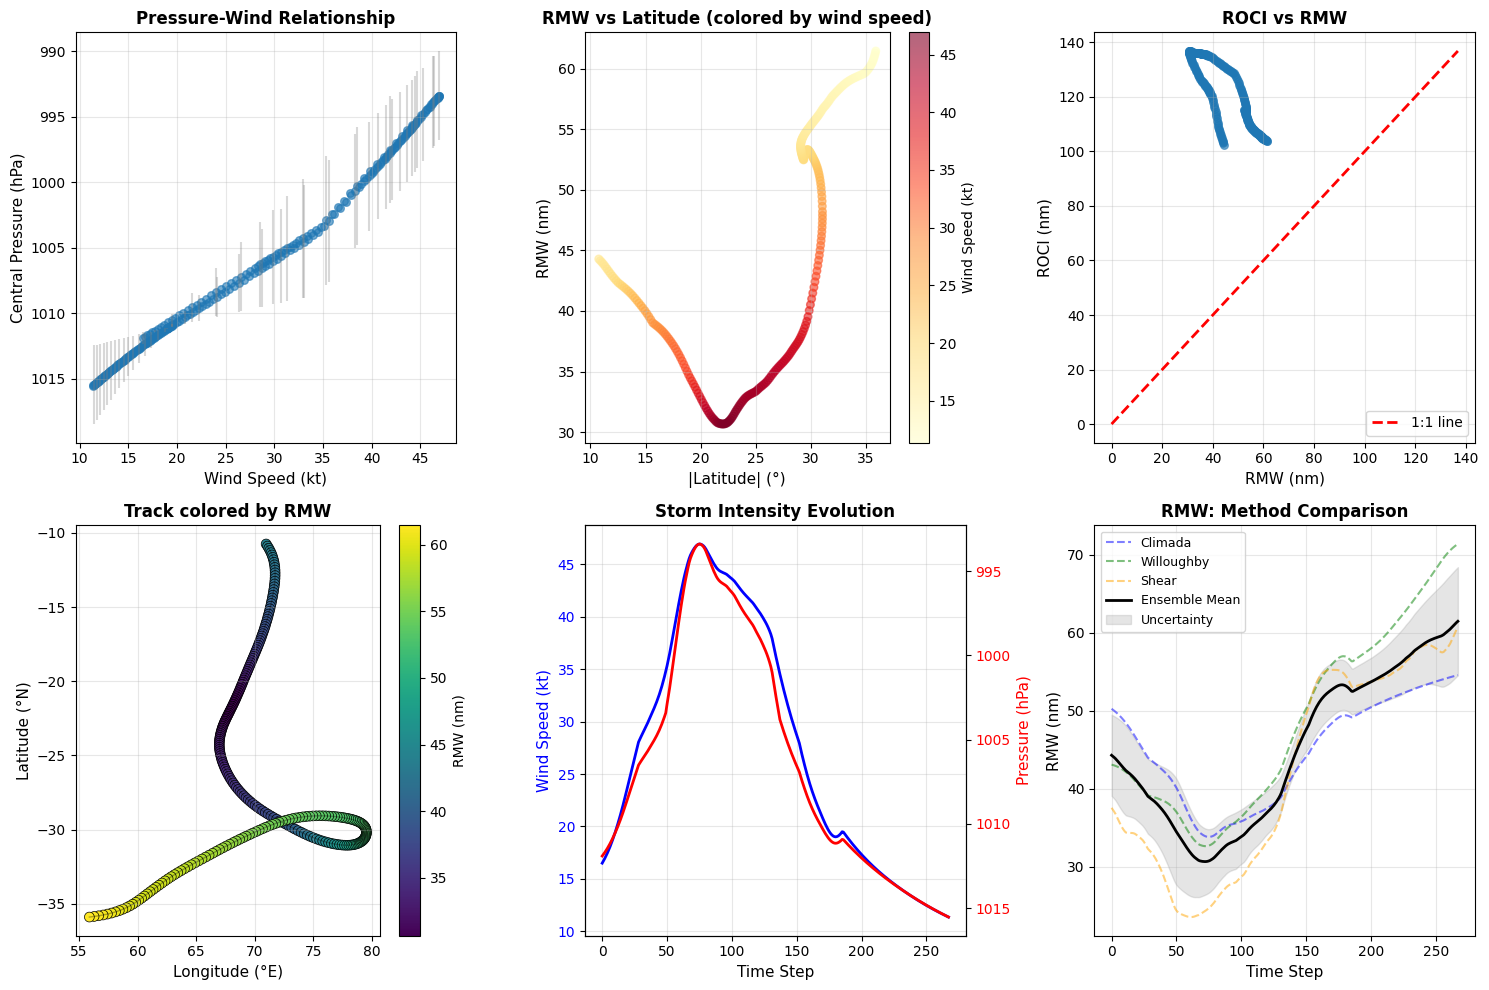


PROCESSING COMPLETE


In [7]:
file_path = '/mnt/team/rapidresponse/pub/tropical-storms/tc_risk/output/cmip6/ACCESS-CM2/r1i1p1f1/historical/1970-1989/SI/tracks_SI_ACCESS-CM2_historical_r1i1p1f1_197001_198912_e9.nc'

import xarray as xr

# Load your track data from netCDF
ds = xr.open_dataset(file_path)

# Select a single track
track = ds.sel(year=1970, n_trk=0)

# Process the track
results = process_track(
    lon_trks=track.lon_trks.values,
    lat_trks=track.lat_trks.values,
    vmax_trks=track.vmax_trks.values,
    u850_trks=track.u850_trks.values,
    v850_trks=track.v850_trks.values,
    u250_trks=track.u250_trks.values,
    v250_trks=track.v250_trks.values,
    tc_basins=track.tc_basins.values.item(),
    plot=True,
    verbose=True
)

